In [1]:
import numpy as np
from scipy.stats import special_ortho_group as SO
from time import time

import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [17]:
import uproot
import utils
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt

filenames = glob.glob('../cache/*.root')

def decode_energy(fn):
    return utils.hex_to_float(fn.split('_')[-1].replace('.root', '').replace('o', '.'))


fn = filenames[0]
energy = decode_energy(fn)
print(energy)

with uproot.open(fn) as file:
    rawEventID = file['LXe;1']['Event'].array(library='np')
    rawEd = -file['LXe;1']['Ed'].array(library='np')
    rawX = file['LXe;1']['X'].array(library='np')
    rawY = file['LXe;1']['Y'].array(library='np')
    rawZ = file['LXe;1']['Z'].array(library='np')

15.0


In [18]:
num = 1000

mask = rawEd > 0
mask &= (rawEventID >= 0) & (rawEventID < num)

Ed = rawEd[mask]
X = rawX[mask]
Y = rawY[mask]
Z = rawZ[mask]
EventID = rawEventID[mask]

In [19]:
SO3 = SO(3)

tmp = np.stack([X, Y, Z]).T

for _id in tqdm(range(num), desc='Rotating'):
    mask = EventID == _id
    rot = SO3.rvs()
    tmp[mask] = np.dot(tmp[mask], rot)
    
X = tmp[:, 0]
Y = tmp[:, 1]
Z = tmp[:, 2]

Rotating: 100%|██████████| 1000/1000 [00:01<00:00, 694.94it/s]


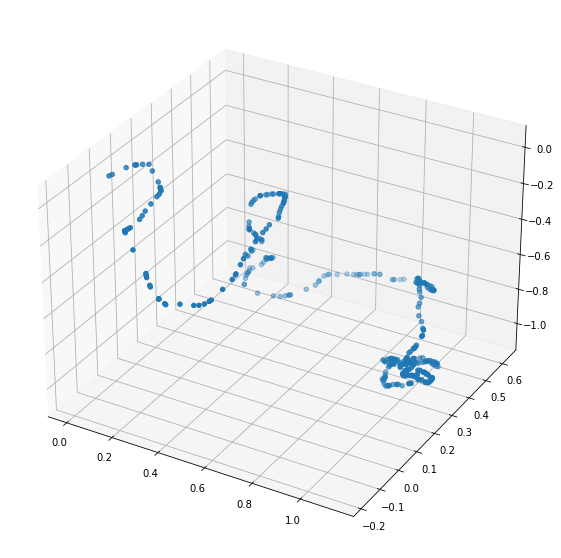

In [20]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(X[EventID==0], Y[EventID==0], Z[EventID==0])
plt.show()

In [21]:
energy, np.sum(Ed[EventID==0])

(15.0, 15.000236198075411)

In [5]:
gpu_kernels = open('./CudaKernels.cpp', 'r').read()
mod = SourceModule(gpu_kernels)
func = mod.get_function('calculate_recomb')

In [6]:
def make_gpu_args(X, Y, Ed, EventID, params):
    # in
    num_event = np.asarray(len(np.unique(EventID))).astype(np.int32)
    print("num_event \t= %i" % num_event[()])
    
    # in
    params = np.asarray(params).astype(np.float32)
    
    # in
    X = np.asarray(X).astype(np.float32)
    Y = np.asarray(Y).astype(np.float32)
    Ed = np.asarray(Ed).astype(np.float32)

    # in
    event_end = np.argwhere(np.diff(EventID, prepend=-1, append=num_event+1)!=0).ravel()
    event_end = np.asarray(event_end).astype(np.int32)
    
    # placeholders
    # in
    X_edge = np.zeros(2 * len(X)).astype(np.float32)
    Y_edge = np.zeros(2 * len(Y)).astype(np.float32)

    # in
    X_edge_ID = np.zeros(2 * len(X)).astype(np.int32)
    Y_edge_ID = np.zeros(2 * len(Y)).astype(np.int32)

    # in
    _, num_hits = np.unique(EventID, return_counts=True)
    weight = np.zeros(np.sum((2*num_hits-1)**2)).astype(np.float32)

    # in
    recomb = np.zeros(num_event).astype(np.float32)

    # in
    fcache = np.zeros(4 * len(X)).astype(np.float32)
    icache = np.zeros(4 * len(X)).astype(np.int32)
    
    mem_bytes = np.sum([arr.nbytes for arr in [num_event, params, X, Y, Ed, event_end, X_edge, Y_edge, X_edge_ID, Y_edge_ID, weight, recomb, fcache, icache]])
    print("Memory used \t= %i MB" % (mem_bytes/1e6))
    
    gpu_args = [
        drv.In(X),
        drv.In(Y),
        drv.In(Ed),
        drv.In(event_end),
        drv.In(num_event),
        drv.In(params),
        drv.In(X_edge),
        drv.In(Y_edge),
        drv.In(X_edge_ID),
        drv.In(Y_edge_ID),
        drv.In(weight),
        drv.In(fcache),
        drv.In(icache),
        drv.InOut(recomb)
    ]
    
    other_kwargs = {
        "num_event" : int(num_event[()]),
        "params" : params,
        "recomb_alloc" : gpu_args[-1],
        "auto_block" : (int(num_event[()]), 1, 1)
    }
    
    return gpu_args, other_kwargs

In [7]:
def free_gpu_args(args):
    if args == []:
        return
    for gpu_arr in args:
        alloc = gpu_arr.get_device_alloc()
        alloc.free()

In [8]:
n_alpha = 2
n_beta = 2
alpha = np.linspace(0, 10.0, n_alpha + 1)[1:]
beta = np.linspace(0, 30.0, n_beta + 1)[1:]

In [9]:
gpu_args, kwargs = make_gpu_args(X, Y, Ed, EventID, [6.0, 15.0])

num_event 	= 1000
Memory used 	= 713 MB


In [10]:
cache = np.zeros(n_alpha * n_beta, dtype=[
    ('alpha', float),
    ('beta', float),
    ('recomb', (float, (num,)))
])

for i in tqdm(range(n_alpha)):
    for j in range(n_beta):
        print(i, j, alpha[i], beta[j])
        
        gpu_args[5].get_device_alloc().free()
        gpu_args[5] = drv.In(
            np.asarray([alpha[i], beta[j]]).astype(np.float32)
        )
        func(*gpu_args, block=kwargs['auto_block'])
        
        cache[i * n_beta + j]['alpha'] = alpha[i]
        cache[i * n_beta + j]['beta'] = beta[i]
        cache[i * n_beta + j]['recomb'] = kwargs['recomb_alloc'].array

  0%|          | 0/2 [00:00<?, ?it/s]

0 0 5.0 15.0
0 1 5.0 30.0


 50%|█████     | 1/2 [00:43<00:43, 43.24s/it]

1 0 10.0 15.0


 50%|█████     | 1/2 [01:04<01:04, 64.75s/it]


KeyboardInterrupt: 

In [90]:
free_gpu_args(gpu_args)

In [88]:
np.save(open(fn.replace('.root', '.pkl'), 'bw'), cache, allow_pickle=True)

In [94]:
np.load(filenames[1].replace('.root', '.pkl'), allow_pickle=True)

array([( 5., 15., [0.49893516, 0.50303888, 0.48954493, 0.50155032, 0.4992218 , 0.50033379, 0.50465602, 0.49066854, 0.50442338, 0.49899268]),
       ( 5., 15., [0.63957357, 0.64390355, 0.63061321, 0.64219546, 0.64024699, 0.64109778, 0.64541125, 0.631576  , 0.64538556, 0.63999546]),
       (10., 30., [0.23102111, 0.23200673, 0.22788173, 0.23181748, 0.23096442, 0.23132306, 0.23260421, 0.22823209, 0.23251122, 0.23082268]),
       (10., 30., [0.36029828, 0.36181772, 0.35608977, 0.36140829, 0.36028826, 0.36078846, 0.36257553, 0.3565889 , 0.36245781, 0.36014146])],
      dtype=[('alpha', '<f8'), ('beta', '<f8'), ('recomb', '<f8', (10,))])